In [ ]:
import string
import copy
import scipy
import Tkinter, tkFileDialog
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import re
import sys
import cPickle
import glob
sys.path.append(os.path.abspath("C:\Users\Scherer Lab E\Documents\GitHub\Python_Data_Analysis"))
import common_functions as cf
import half_nanoplate_functions as hnf

In [2]:
cd "K:\Pat's_Projects\ParticleTrajectoryData"

K:\Pat's_Projects\ParticleTrajectoryData


In [3]:
store = pd.HDFStore('half_nanoplate_dynamics_processed.h5', mode='r')

## Force Distribution from Instantanous Speeds

To calculate the force for the kinetic models I first filter all the trajectories so that I am only looking at trajectories between 120 deg and 260 deg which is over the nanoplate but far from the edges. From those trajectories I calculate the single frame displacements (in x and y) which multiplied by the frame rate yeilds and instantaneous speed for each particle in each frame. These speeds are used in Stokes Law to calculate the force applied to the particle. The average force is used in the Bell and Szabo kinetic models while the standard deviation of the forces is used to create the error bars.

Because I am calculating the speed and not the velocity the forces I calculate can never be negative. This leads to a distribution of forces where the minimum is 0. Curtis mentions that he fits a Guassian to his data in order to retrieve the standard deviation. I don't think this can be done because the force distributions for low L's are asymmetric.

In [4]:
'''Calculate the velocities over nanoplate and Stokes drag forces for each 
velocity. Calculate the mean and deviation in the forces for each L'''
keys = store.index['key']
results = pd.DataFrame()
results['L'] = store.index['L']
velocity_list = []
force_list = []
mean_force = []
std_force = []
for i,key in enumerate(keys):
    df = store.get(key).copy()
    velocities = hnf.calc_velocities_consec_frames(df, theta_range=[120,240], only_over_plate=True)
    forces = hnf.calc_force_stokes_drag(velocities)
    velocity_list.append(velocities)
    force_list.append(forces)
    mean_force.append(forces.mean())
    std_force.append(forces.std())

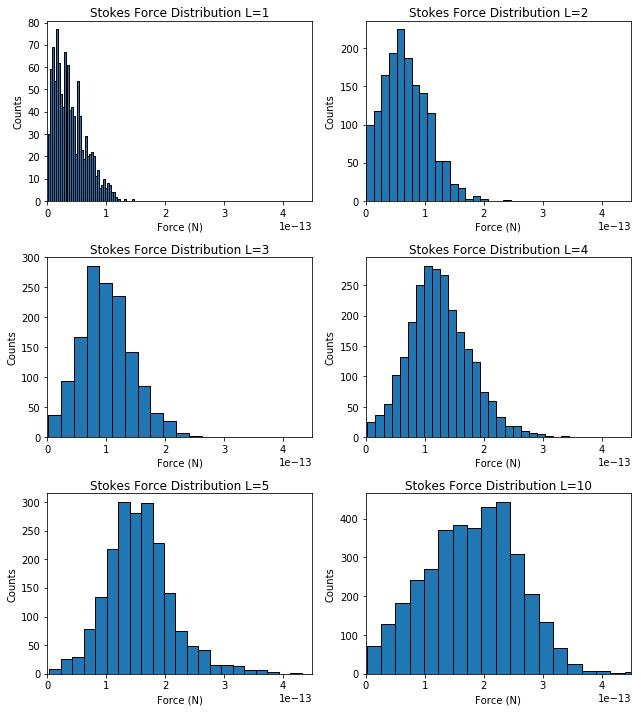

In [6]:
L_list = [1, 2, 3, 4, 5, 10]
plt.figure(figsize=(9, 10))
for num, v in enumerate(force_list):
    bin_numbers = hnf.hist_bin_optimization_continuous(v)
    plt.subplot(3,2,num+1)
    plt.hist(v, edgecolor='k', bins=bin_numbers)
    plt.title("Stokes Force Distribution L="+str(L_list[num]))
    plt.ylabel('Counts')
    plt.xlabel('Force (N)')
    plt.xlim(0,4.5*10**-13)
plt.tight_layout()
plt.show()

## Calculate Force in Theta

A metric that would allow me to sample positive and negative force is if I look at motion of particles in theta and calculate rotational velocity. The problem with this is to do it properly one needs to assume a fixed radius for the particle motion to be constrained to.

Once again I select for a specific region in theta to do this calculation 120-260 degres so I just sample particles over the nanoplate and far from the barriers. However, I do one additional filtering and that is a filted in r between 128 and 140 pixels. The average radius for the particles in all the experiments is around 131 pixels. But in some experiments there are particles that appear in the center of the ring trap (over the nanoplate) and diffuse freely. This results in huge changes in theta and the velocities calculated from these particles (in conjuction with using an average radius to calculate arc length) are extremely large and are just plain wrong. Doing a modest filtering in radius prevents such outliers from affecting the data. (Perhaps I should consider doing a statistical test to eliminate outliers in the future.)

In [7]:
def displacement_in_theta_calc(group):
    '''Calculates the displacement of the group with a theta position. Use with
    pandas groupby and apply.

    :param group: DataFrame with 'theta' column and contains only one 'track id'
    '''
    group_non_consec_index = group[group.frame - group.shift(1).frame > 1].index
    group.loc[group_non_consec_index, ['theta']] = np.nan
    theta_data = group['theta']
    theta_disp = theta_data - theta_data.shift(1)
    theta_disp = theta_disp.dropna()
    return theta_disp

In [8]:
default_um_conv = 6.5/60.0/1.6/2.00
default_frame_rate = 90.00
default_radius = 0.075
default_viscosity = 1.002

def calc_velocities_consec_frames_in_theta(df, frame_rate=default_frame_rate, um_conv=default_um_conv, theta_range=[120,240], r_range=[128,140], only_over_plate=True):
    '''Calculates the velocity of particles in theta from a data frame within a specified part of the ring
    trap and only counts consecutive frames (where the particle does not disappear). The average radius
    of the particles within the designated theta region is used to calculate the arc traveled
    in the ring trap.

    :param df: DataFrame that contains the trajectory information with keys 
    ['frame','track id', 'theta', 'over_plate']
    :param frame_rate: The frame rate that the experiment was recorded at
    :param um_conv: The conversion factor to convert position from pixels to um.
    :param theta_range: Tuple (2 elements) which describe the lower and upper limits of theta that you want
    to find the velocity of particles over (e.g. the theta range of particles over the nanoplate)
    :param r_range: Tuple (2 elements) which describes the upper and lower cutoff in radius for 
    allowed trajectories. This prevents outliers of particles moving great distances
    in theta in the center of the ring (not in the ring trap).
    :param over_plate: If True then only particles over the nanoplate are considered. If False all particles
    velocities are calculated.
    '''
    df_temp = df.query('@theta_range[0] < theta < @theta_range[1]')
    df_temp = df_temp.query('@r_range[0] < r < @r_range [1]')
    if only_over_plate == True:
        df_temp = df_temp[df_temp['over_plate'] == True]
    df_temp = df_temp.drop_duplicates(subset=['frame', 'track id'], keep='first')
    r_avg = df_temp.r.mean()
    displacements_theta = df_temp.groupby('track id', group_keys=False).apply(displacement_in_theta_calc) 
    velocities = displacements_theta* r_avg * (np.pi/180) * um_conv * frame_rate
    return velocities

In [9]:
'''Calculate the velocities over nanoplate and Stokes drag forces for each 
velocity. Calculate the mean and deviation in the forces for each L'''
keys = store.index['key']
results = pd.DataFrame()
results['L'] = store.index['L']
velocity_list_theta = []
force_list_theta = []
mean_force_theta = []
std_force_theta = []
for i,key in enumerate(keys):
    df = store.get(key).copy()
    velocities_theta = calc_velocities_consec_frames_in_theta(df, theta_range=[120,240], only_over_plate=True)
    forces_theta = hnf.calc_force_stokes_drag(velocities_theta)
    velocity_list_theta.append(velocities_theta)
    force_list_theta.append(forces_theta)
    mean_force_theta.append(forces_theta.mean())
    std_force_theta.append(forces_theta.std())

In [10]:
def hist_bin_optimization_continuous(data, data_range=None, max_bins=200):
    '''Uses the Shimazaki histogram binwidth optimization for a given
    data set of continuous data and returns the optimal number of bins
    
    This function attempts to find the optimal number of bins for a 
    data set you want to histogram. The optimization method was 
    developed by Shimazaki with ref:
    
    Shimazaki and Shinomoto. Neural Comput, 2007, 19(6), 1503-1527
    
    The function should work with any continuous data set.
    
    :param data: List or array of your data that you will histogram
    :param (tuple) data_range: The range that you plan on making a
    histogram of the data. You should use this range when you make your
    histogram after finding the optimal number of bins.
    :param (int) max_bins: The maximum number of bins you will allow for
    the given range. Your max bins must be less than your sampling
    frequency. If you data looks over binned try reducing this number
    '''
    
    if data_range == None:
        data_range = [min(data), max(data)]
    bin_numbers = range(1,max_bins)
    cost_results = []
    for bin_num in bin_numbers:
        bin_width = (data_range[1] - data_range[0])/float(bin_num)
        counts, bins = np.histogram(data, bins=bin_num, range=data_range)
        mean_counts = np.mean(counts)
        variance = np.sum((counts - mean_counts)**2)/float(bin_num)
        c = (2*mean_counts - variance)/float(bin_width)**2
        cost_results.append(c)
    cost_results = np.array(cost_results)
    idx_min_cost = np.argmin(cost_results)
    return bin_numbers[idx_min_cost]

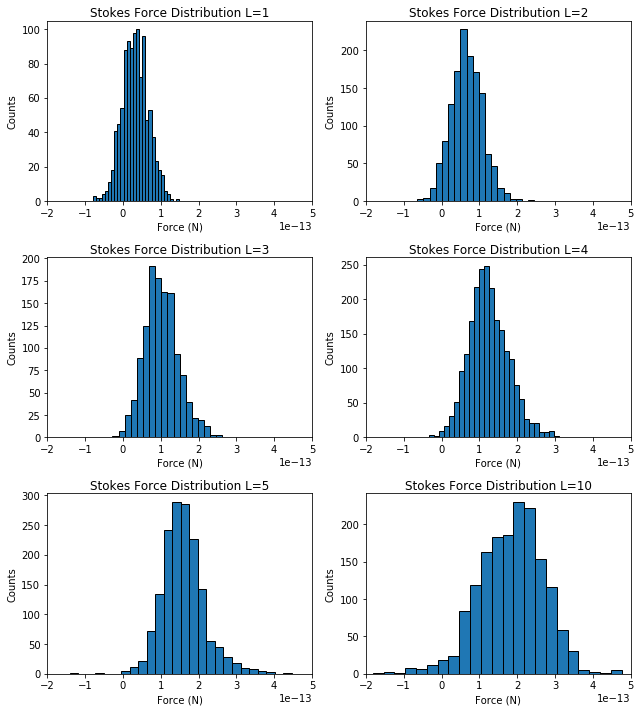

In [11]:
L_list = [1, 2, 3, 4, 5, 10]
plt.figure(figsize=(9, 10))
for num, v in enumerate(force_list_theta):
    bin_numbers = hist_bin_optimization_continuous(v)
    plt.subplot(3,2,num+1)
    plt.hist(v, edgecolor='k', bins=bin_numbers)
    plt.title("Stokes Force Distribution L="+str(L_list[num]))
    plt.ylabel('Counts')
    plt.xlabel('Force (N)')
    plt.xlim(-2*10**-13,5*10**-13)
plt.tight_layout()
plt.show()

In [12]:
import cPickle

pickle_file = open("C:\Users\Scherer Lab E\Box Sync\Half-Nanoplate\Figures and Data\Data\\force_distributions_expt.pkl", 'w')
cPickle.dump([x*10**12 for x in force_list_theta], pickle_file)
pickle_file.close()

## Speed from Counting Particles Crossing Region

Curtis found average speed by looking at the time it would take for a particle to cross a defined region. This method requires a lot of filtering of the trajectories and the trajectories that were used had the following characteristics:

* The particle must be seen entering the region from outside of it at the beginning of its trajectory
* The particle must be seen leaving the region from within it at the end of its trajectory
* The particle's trajectory must be continous within the region.
* For each particle only the longes trajectory is considered.

Once each of these trajectories are identified they are used to calculate the speed. When these particles enter the region the number of frames it spends in the region is counted until it leaves the region. The distance it was seen traveling in the region (different for each particle) was divided by the time it took to travel that distances resulting in a speed. The distribution of speeds is plotted.

Note: Doing all this filtering really reduces the number of counts I get from each experiment to a maximum of the number of particles that traverse the plate, only one speed is gathered for each particle.

In [13]:
drop_group = ['x pos','theta_nn_num', 'particle id', 'over_plate', 'y pos', 'r', 'nn_num', 'nn_id', 'nn_dist', 'theta_nn_id', 'theta_nn_dist']

def check_exiting_region(group):
    '''Returns the entries where particles that are in the region will be found
    outside the region the next time they could be identified. This should be used 
    with a groupby on a data frame grouped by 'track id'. 
    
    :pram group: The group from the groupby operation, should be no duplicate
    entries w.r.t. frame and track id. Must have a boolean column 'in_region'.
    '''
    new_group = group.iloc[:-1]
    cur_bool = group.in_region.iloc[:-1]
    fut_bool = group.in_region.shift(-1).iloc[:-1].astype(np.bool)
    return new_group[(cur_bool & ~fut_bool)]

def check_entering_region(group):
    '''Returns the entries where particles that are in the region that were just 
    outside the region last time they could be identified. This should be used 
    with a groupby on a data frame grouped by 'track id'. 
    
    :pram group: The group from the groupby operation, should be no duplicate
    entries w.r.t. frame and track id. Must have a boolean column 'in_region'
    '''
    new_group = group.iloc[1:]
    cur_bool = group.in_region.iloc[1:]
    past_bool = group.in_region.shift(1).iloc[1:].astype(np.bool)
    return new_group[(cur_bool & ~past_bool)]

def find_longest_trajs_in_group_in_region(group):
    '''Returns only the entries in the data frame that represent the longest
    trajectory in a region for each 'track id'. This should be used with 
    groupby on a DataFrame grouped by 'track id' with boolean values for
    particles entering and leaving the region.
    
    :param group: A 'track id' group from the groupby operation. Should have
    no duplicate entries w.r.t. frame and 'track id'. Must have boolean 
    columns 'first_frame_region' and 'last_frame_region'
    '''
    # Find trajectories that enter and exit region
    ent_group = group.first_frame_region == True
    exit_group = group.last_frame_region == True
    ent_exit_group = group[ent_group | exit_group]
    
    # Return if particle doesn't have both and entrance and exit
    if len(ent_exit_group) == 1:
        return pd.DataFrame(columns=group.columns)
    
    # Find start index of longest traj
    frames = ent_exit_group.shift(-1).frame - ent_exit_group.frame
    if len(frames) == 0:
        return pd.DataFrame(columns=group.columns)
    start = frames.idxmax()
    if group.loc[start, 'last_frame_region'] == True:
        return pd.DataFrame(columns=group.columns)
    
    # Find end index of longest traj
    frames = ent_exit_group.frame - ent_exit_group.shift(1).frame
    if len(frames) == 0:
        return pd.DataFrame(columns=group.columns)
    end = frames.idxmax()
    if group.loc[end, 'first_frame_region'] == True:
        return pd.DataFrame(columns=group.columns)
    
    return group.ix[start:end]


def find_longest_trajs_in_region(df, theta_range=(120,240)):
    '''Returns a data frame of trajectories of only the longest consecutive 
    trajectories in a defined region.
    
    This function accepts a DataFrame of rotational trajectories and allows you
    to find the longest consecutive trajectories in a selected region. First 
    particle trajectories are cut to just the ones that are in the region. Next,
    for each trajectory (track id) that passes through the region only the longest
    one is kept. The trajectories that are returned must move from outside the
    region into it and also must move from inside the region to outside of it in
    order for the trajectory to be considered. Having these critera prevents 
    counting trajectories of particles that 'appear' in the region (and not seen
    outside first) or particles that 'disappear' out fo the region (and not seen
    again). This should give trajectories that are continuous and move all the 
    way through the region.
    
    Note: This function does not respect periodic boundary conditions. You 
    cannot use a theta range that spans across 0 degrees.
    
    :param df: DataFrame of trajectories to be analyzed. Does not need to have
    unique values w.r.t. 'frame' and 'track id'.
    :param (tuple) theta_range: Tuple (2 elements) wich describes the region you
    will be selecting the longest trajectories from.
    '''
    # Designate if particle positions are in the region with 'in_region" column
    df_unique = df.copy().drop_duplicates(subset=['frame', 'track id'], keep='first')
    df_in_region = (theta_range[0] < df_unique.theta) & (df_unique.theta < theta_range[1])
    df_unique.loc[df_in_region, 'in_region'] = True
    df_unique.loc[~df_in_region, 'in_region'] = False
    
    # Find positions where particles just enter or exit the region
    entering_region = df_unique.groupby('track id', group_keys=False).apply(check_entering_region)
    exiting_region = df_unique.groupby('track id', group_keys=False).apply(check_exiting_region)
    
    # Designate which positions are the first/last frame in the region
    df_unique['first_frame_region'] = False
    df_unique['last_frame_region'] = False
    df_unique.loc[entering_region.index, 'first_frame_region'] = True
    df_unique.loc[exiting_region.index, 'last_frame_region'] = True
    
    # Determine the longest consecutive trajectory in the region
    df_long_traj_in_region = df_unique.groupby('track id', group_keys=False).apply(find_longest_trajs_in_group_in_region)
    return df_long_traj_in_region

In [14]:
um_conv = 6.5/60.0/1.6/2.00
frame_rate = 90.00

force_list_travel_time = []
mean_force_travel_time = []
std_force_travel_time = []
for num,key in enumerate(keys):
    df = store.get(key).copy()
    df_in_region = find_longest_trajs_in_region(df, theta_range=(120,240))
    r_mean = df_in_region.r.mean()
    
    frame_diff = lambda x: x.iloc[-1].frame - x.iloc[0].frame
    times = df_in_region.groupby('track id').apply(frame_diff)
    dist_diff = lambda x: x.iloc[-1].theta - x.iloc[0].theta
    distances = df_in_region.groupby('track id').apply(dist_diff)
    
    speed = distances / times
    
    speed_um = speed * (np.pi/180.0) * r_mean * um_conv *90.0
    forces = hnf.calc_force_stokes_drag(speed_um) 
    force_list_travel_time.append(forces)
    mean_force_travel_time.append(forces.mean())
    std_force_travel_time.append(forces.std())

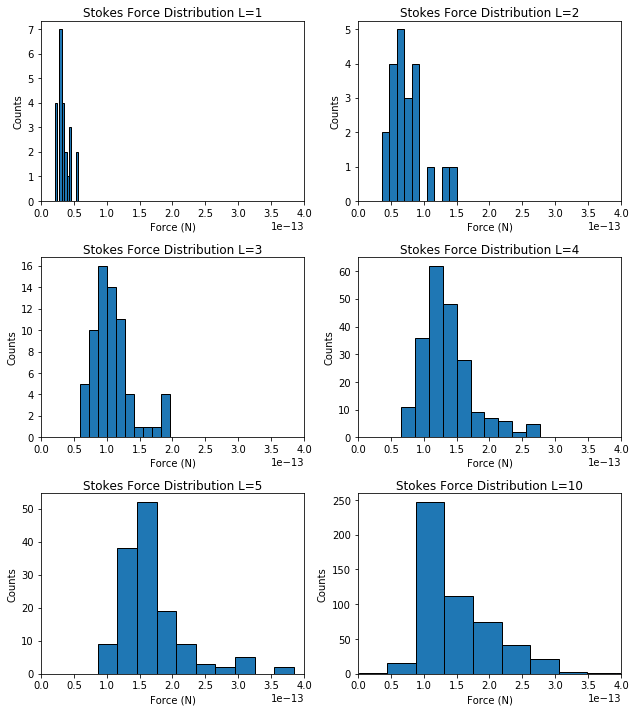

In [15]:
L_list = [1, 2, 3, 4, 5, 10]
plt.figure(figsize=(9, 10))
for num, v in enumerate(force_list_travel_time):
    #bin_numbers = hist_bin_optimization_continuous(v)
    plt.subplot(3,2,num+1)
    plt.hist(v, edgecolor='k')#, bins=bin_numbers)
    plt.title("Stokes Force Distribution L="+str(L_list[num]))
    plt.ylabel('Counts')
    plt.xlabel('Force (N)')
    plt.xlim(0,4*10**-13)
    
plt.tight_layout()
plt.show()

### Compare Mean and Std Dev for Various Methods

To summarize the results the means and standard deviations of each of the three methods are shown below.

In [16]:
import ipywidgets
summ = pd.DataFrame()
summ['L'] = [1,2,3,4,5,10]
summ['Mean Inst Speeds'] = np.asarray(mean_force)*10**12
summ['Std Inst Speeds'] = np.asarray(std_force)*10**12
summ['Mean Inst Speeds Theta'] = np.asarray(mean_force_theta)*10**12
summ['Std Inst Speeds Theta'] = np.asarray(std_force_theta)*10**12
summ['Mean Travel Time'] = np.asarray(mean_force_travel_time)*10**12
summ['Std Travel Time'] = np.asarray(std_force_travel_time)*10**12
summ.style.format({"Std Inst Speeds": lambda x: "$\pm${:.3f}".format(abs(x)),
                  "Std Inst Speeds Theta": lambda x: "$\pm${:.3f}".format(abs(x)),
                  "Std Travel Time": lambda x: "$\pm${:.3f}".format(abs(x)),
                  "Mean Inst Speeds": lambda x: "{:.3f}".format(x),
                  "Mean Inst Speeds Theta": lambda x: "{:.3f}".format(x),
                  "Mean Travel Time": lambda x: "{:.3f}".format(x),})

In [17]:
theta_summ = []
for theta_upper_cutoff in range(130, 270, 10):
    keys = store.index['key']
    results = pd.DataFrame()
    results['L'] = store.index['L']
    velocity_list = []
    force_list = []
    mean_force = []
    std_force = []
    for i,key in enumerate(keys):
        df = store.get(key).copy()
        velocities = hnf.calc_velocities_consec_frames(df, theta_range=[120,theta_upper_cutoff], only_over_plate=True)
        forces = hnf.calc_force_stokes_drag(velocities)
        velocity_list.append(velocities)
        force_list.append(forces)
        mean_force.append(forces.mean())
        std_force.append(forces.std())

    keys = store.index['key']
    results = pd.DataFrame()
    results['L'] = store.index['L']
    velocity_list_theta = []
    force_list_theta = []
    mean_force_theta = []
    std_force_theta = []
    for i,key in enumerate(keys):
        df = store.get(key).copy()
        velocities_theta = calc_velocities_consec_frames_in_theta(df, theta_range=[120,theta_upper_cutoff], only_over_plate=True)
        forces_theta = hnf.calc_force_stokes_drag(velocities_theta)
        velocity_list_theta.append(velocities_theta)
        force_list_theta.append(forces_theta)
        mean_force_theta.append(forces_theta.mean())
        std_force_theta.append(forces_theta.std())

    force_list_travel_time = []
    mean_force_travel_time = []
    std_force_travel_time = []
    for num,key in enumerate(keys):
        df = store.get(key).copy()
        df_in_region = find_longest_trajs_in_region(df, theta_range=(120,theta_upper_cutoff))
        r_mean = df_in_region.r.mean()

        frame_diff = lambda x: x.iloc[-1].frame - x.iloc[0].frame
        times = df_in_region.groupby('track id').apply(frame_diff)
        dist_diff = lambda x: x.iloc[-1].theta - x.iloc[0].theta
        distances = df_in_region.groupby('track id').apply(dist_diff)

        speed = distances / times

        speed_um = speed * (np.pi/180.0) * r_mean * um_conv *90.0
        forces = hnf.calc_force_stokes_drag(speed_um) 
        force_list_travel_time.append(forces)
        mean_force_travel_time.append(forces.mean())
        std_force_travel_time.append(forces.std())
        
    summ = pd.DataFrame()
    summ['L'] = [1,2,3,4,5,10]
    summ['Mean Inst Speeds'] = np.asarray(mean_force)*10**12
    summ['Std Inst Speeds'] = np.asarray(std_force)*10**12
    summ['Mean Inst Speeds Theta'] = np.asarray(mean_force_theta)*10**12
    summ['Std Inst Speeds Theta'] = np.asarray(std_force_theta)*10**12
    summ['Mean Travel Time'] = np.asarray(mean_force_travel_time)*10**12
    summ['Std Travel Time'] = np.asarray(std_force_travel_time)*10**12
    
    theta_summ.append((theta_upper_cutoff, summ))

In [18]:
for num, theta_pt in enumerate(theta_summ):
    theta_cutoff = theta_pt[0]
    summ_table = theta_pt[1]
    if num == 0:
        array = summ_table.values
        theta_cutoff_list = [theta_cutoff]
    else:
        array = np.dstack((array, summ_table.values))
        theta_cutoff_list.append(theta_cutoff)

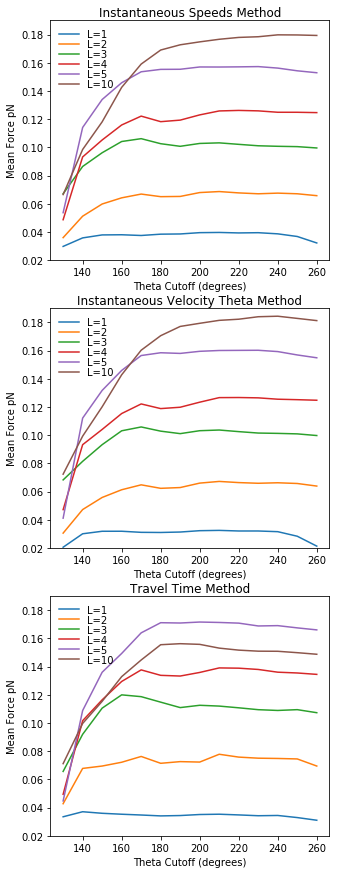

In [19]:
titles = ['Instantaneous Speeds Method', 'Instantaneous Velocity Theta Method', 'Travel Time Method']
plt.figure(figsize=(5,15))
for i in range(3):
    method_mean = array[:, i*2+1, :]
    L_s = array[:,0,0]
    plt.subplot(3,1,i+1)
    for v in range(len(method_mean[:,0])):
        plt.plot(theta_cutoff_list, method_mean[v,:], label='L='+str(int(L_s[v])))
    plt.xlabel('Theta Cutoff (degrees)')
    plt.ylabel('Mean Force pN')
    plt.title(titles[i])
    plt.legend(frameon=False, labelspacing=0)
    plt.ylim(0.020, 0.19)

plt.show()

In [20]:
store.close()